# Kernel

all step taken for advance lane detection.

In [2]:
# import necessary library
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import math
print('done')

done


## Camera Undistortion

normally each camera will have some distortion that make some part of the image produced, have incorrect shape(sligh curve the main error is the silgh curve of the straight line near the egdes of the image).

The method that will be using here is following the [OpenCV tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)

To sumup the step to do the undistort are as followed;
*  took an image of cheesboard pattern in many position
*  find all the chessboard corners
*  calculate and calibrate the distortion value(using some library)
*  use this to undistort the image yay!

In [8]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

In [15]:
# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")
print(images)
print('num of all image: ' + str(len(images)))

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']
num of all image: 20


In [23]:
# config subplot
num_img = len(images)
col = 4 # 4 image each row
row = math.ceil(num_img/col)

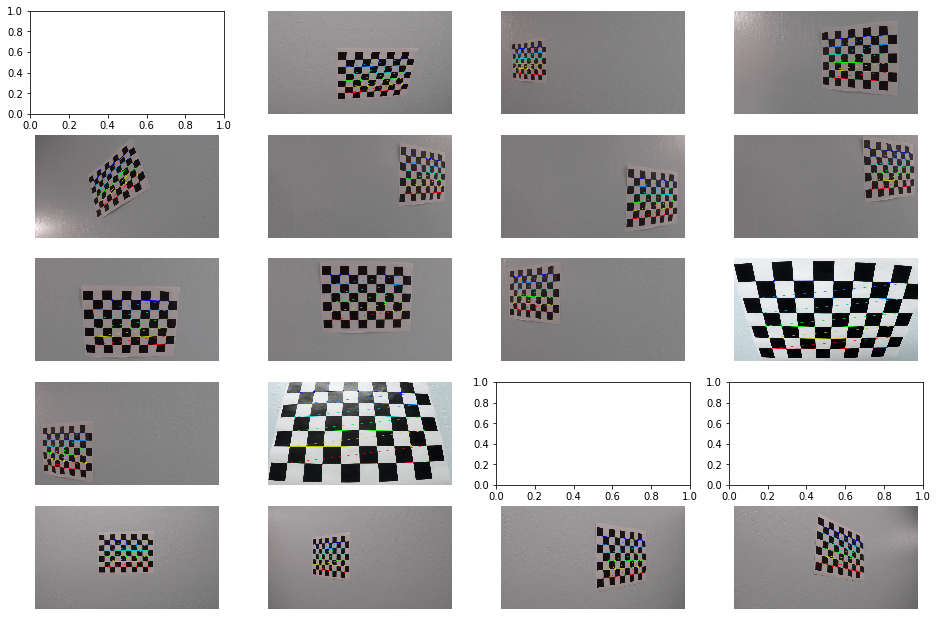

In [24]:
fig, axs = plt.subplots(row,col, figsize=(16, 11))
#fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)
        axs[i].axis('off')
        axs[i].imshow(img)


cv2.destroyAllWindows()

In [28]:
# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

...


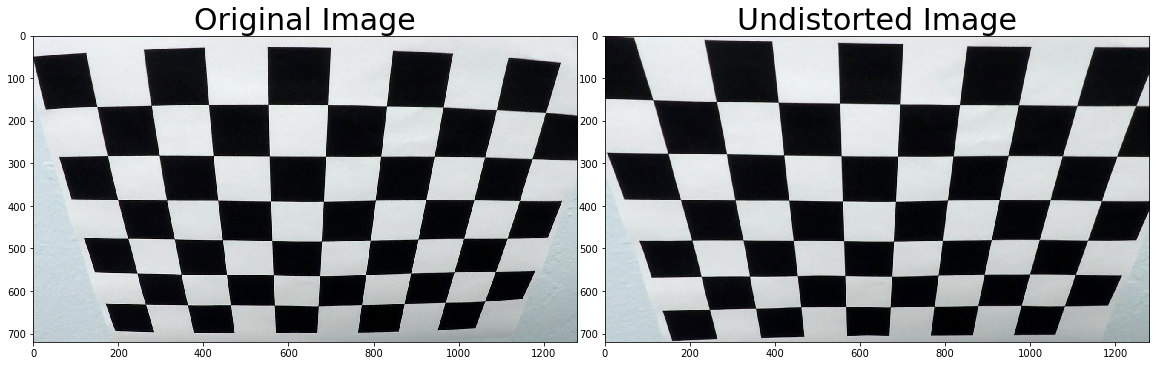

In [32]:
# test put our calibration parameter
test_img = cv2.imread(images[11])
dst = cv2.undistort(test_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [33]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

## Testing with the road image

now let's try the calibration in some more realistic image

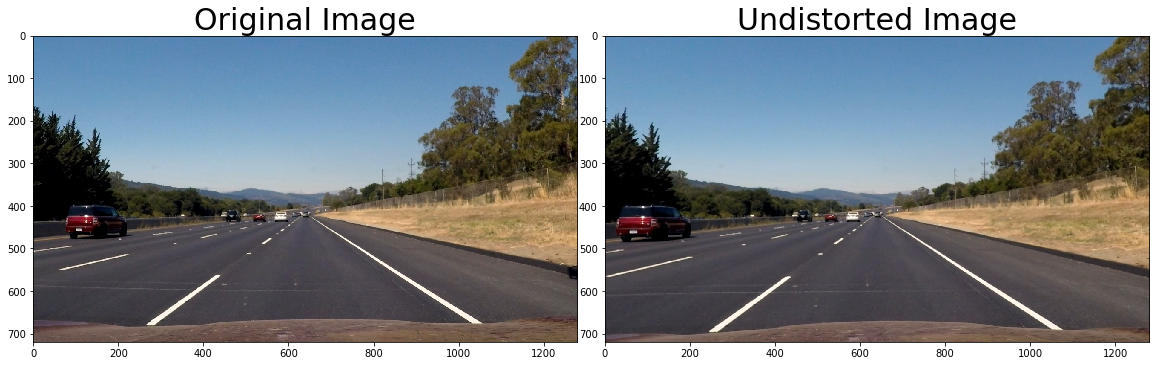

In [22]:
test_img = cv2.imread(glob.glob("test_images/*.jpg")[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
dist_pickle = pickle.load(open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
undist_img = dst # for next step use
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Perspective transform

Next, what we want to do is covert our image from front view into bird's eye view.
Why do we want to do that? well to remove the persective effect on our image.
the figure above is a great example. Despite the line being a straight line, it appear as it is a Diagonal line toward the center. The line near the camera be wider than the one further away. 
this can be remove when we transform the image into bird's eyeview where everypart of the image have similar distance.

how we gonna do so? well similar to undistortion we select part of the image where we know it is a strait line and mapping it into the output image.

In [21]:
# get the image shape
h,w = undist_img.shape[:2]

# define sources point and destionation that it will mapping to
src_pts = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])



In [24]:
print(undist_img.shape)

(720, 1280, 3)
